In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mrigaankjaswal/exercise-detection-dataset")

print("Path to dataset files:", path)

/home/kelvin/miniconda3/envs/linux-deep-gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 1.39M/1.39M [00:01<00:00, 1.04MB/s]

Extracting files...
Path to dataset files: /home/kelvin/.cache/kagglehub/datasets/mrigaankjaswal/exercise-detection-dataset/versions/1


In [7]:
import pandas as pd
import os

# Load the dataset
file_path = os.path.join(path, 'exercise_angles.csv')
df = pd.read_csv(file_path)

print(df.head())


   Side  Shoulder_Angle  Elbow_Angle   Hip_Angle  Knee_Angle  Ankle_Angle  \
0  left       10.639208   174.466813  174.785143  179.848140   179.419276   
1  left       10.590342   174.428706  174.765042  179.775215   179.386147   
2  left       10.546746   174.489431  174.785790  179.660017   179.333710   
3  left       10.487682   174.614913  174.759542  179.614223   179.313926   
4  left       10.412107   174.758503  174.737721  179.570564   179.298805   

   Shoulder_Ground_Angle  Elbow_Ground_Angle  Hip_Ground_Angle  \
0                   90.0                90.0              90.0   
1                   90.0                90.0              90.0   
2                   90.0                90.0              90.0   
3                   90.0                90.0              90.0   
4                   90.0                90.0              90.0   

   Knee_Ground_Angle  Ankle_Ground_Angle          Label  
0               90.0                90.0  Jumping Jacks  
1               90.0    

<Axes: xlabel='Label'>

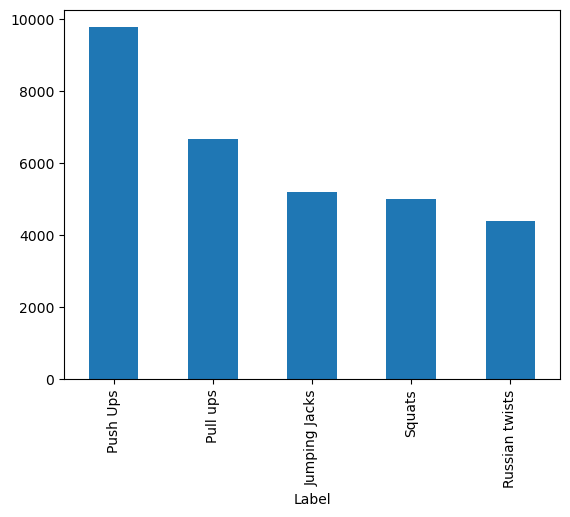

In [10]:
df['Label'].value_counts().plot(kind='bar')

In [11]:
df.shape

(31033, 12)

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

2025-03-05 10:43:25.886552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741171406.112065   12572 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741171406.176000   12572 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 10:43:26.755691: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
features = []

for column in df.columns:
    features.append(column)

targets = features.pop()

In [16]:
del features[0]
features

['Hip_Angle',
 'Knee_Angle',
 'Ankle_Angle',
 'Shoulder_Ground_Angle',
 'Elbow_Ground_Angle',
 'Hip_Ground_Angle',
 'Knee_Ground_Angle',
 'Ankle_Ground_Angle']

In [17]:
targets

'Label'

In [19]:
label_encoder = LabelEncoder()
df[targets] = label_encoder.fit_transform(df[targets])

exercise_predictors = df[features].values
exercise_categories = df[targets].values
exercise_predictors_train, exercise_predictors_test, exercise_categories_train, exercise_categories_test = train_test_split(exercise_predictors, exercise_categories, test_size = 0.2, random_state = 42)

In [20]:
model = keras.Sequential([
    layers.Input(shape = (exercise_predictors_train.shape[1],)),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(len(np.unique(exercise_categories)), activation='softmax')
])
 
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(exercise_predictors_train, exercise_categories_train, epochs=50, batch_size=32, validation_split=0.2)

I0000 00:00:1741171583.102779   12572 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/50


I0000 00:00:1741171588.274834   13822 service.cc:148] XLA service 0x7fd8d4002170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741171588.275550   13822 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-03-05 10:46:28.390894: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741171588.941186   13822 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-03-05 10:46:32.915351: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_555', 68 bytes spill stores, 72 bytes spill loads

2025-03-05 10:46:33.700896: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_557',

 20/621 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3187 - loss: 3.3065 

I0000 00:00:1741171597.975357   13822 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


614/621 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6095 - loss: 1.0619

2025-03-05 10:46:46.719533: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_555', 32 bytes spill stores, 32 bytes spill loads

2025-03-05 10:46:47.381938: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_557', 24 bytes spill stores, 24 bytes spill loads

2025-03-05 10:46:47.880480: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_557', 24 bytes spill stores, 28 bytes spill loads

2025-03-05 10:46:48.099817: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_555', 24 bytes spill stores, 28 bytes spill loads



621/621 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.6101 - loss: 1.0588 - val_accuracy: 0.7205 - val_loss: 0.6691
Epoch 2/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7112 - loss: 0.6555 - val_accuracy: 0.7201 - val_loss: 0.6497
Epoch 3/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7225 - loss: 0.6246 - val_accuracy: 0.7332 - val_loss: 0.6085
Epoch 4/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7253 - loss: 0.6044 - val_accuracy: 0.7338 - val_loss: 0.6515
Epoch 5/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7338 - loss: 0.5909 - val_accuracy: 0.7038 - val_loss: 0.6367
Epoch 6/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7344 - loss: 0.5880 - val_accuracy: 0.7441 - val_loss: 0.5744
Epoch 7/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7466 - loss: 0.5699 - val_accuracy: 0.7414 - val_loss: 0.5643
Epoch 8/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7474 - loss: 0.5566 - val_accuracy: 0.77

In [23]:
model = keras.Sequential([
    layers.Input(shape = (exercise_predictors_train.shape[1],)),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
     layers.Dense(64, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(len(np.unique(exercise_categories)), activation='softmax')
])
 
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              
              metrics = ['accuracy'])

history = model.fit(exercise_predictors_train, exercise_categories_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.6123 - loss: 1.2474 - val_accuracy: 0.7084 - val_loss: 0.7763
Epoch 2/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7063 - loss: 0.6685 - val_accuracy: 0.7173 - val_loss: 0.6753
Epoch 3/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7215 - loss: 0.6319 - val_accuracy: 0.7253 - val_loss: 0.6161
Epoch 4/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7169 - loss: 0.6204 - val_accuracy: 0.7380 - val_loss: 0.5947
Epoch 5/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7288 - loss: 0.5884 - val_accuracy: 0.7449 - val_loss: 0.6046
Epoch 6/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7378 - loss: 0.5834 - val_accuracy: 0.7429 - val_loss: 0.6155
Epoch 7/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7377 - loss: 0.5923 - val_accuracy: 0.7169 - val_loss: 0.6205
Epoch 8/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7404 - loss: 0.5680 - val_acc

In [22]:
model = keras.Sequential([
    layers.Input(shape = (exercise_predictors_train.shape[1],)),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(len(np.unique(exercise_categories)), activation='softmax')
])
 
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              
              metrics = ['accuracy'])

history = model.fit(exercise_predictors_train, exercise_categories_train, epochs=50, batch_size=32, validation_split=0.2)



Epoch 1/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.5979 - loss: 3.0915 - val_accuracy: 0.7000 - val_loss: 0.7856
Epoch 2/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6840 - loss: 0.8948 - val_accuracy: 0.6992 - val_loss: 0.8628
Epoch 3/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7042 - loss: 0.7860 - val_accuracy: 0.6742 - val_loss: 1.0858
Epoch 4/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7074 - loss: 0.7749 - val_accuracy: 0.7128 - val_loss: 0.6830
Epoch 5/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7066 - loss: 0.7240 - val_accuracy: 0.7271 - val_loss: 0.7104
Epoch 6/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7083 - loss: 0.7325 - val_accuracy: 0.7280 - val_loss: 0.6917
Epoch 7/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7256 - loss: 0.6790 - val_accuracy: 0.7306 - val_loss: 0.7279
Epoch 8/50
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7245 - loss: 0.6684 - val_accurac